In [1]:
import time
import argparse
import random
import os
import warnings
from importlib import import_module
import cv2


warnings.filterwarnings('ignore')

import torch
import numpy as np
from tqdm import tqdm

from datasets.data_loader import setup_loader
from datasets.data_loader import CustomDataLoader2
from config import Config
import matplotlib.pyplot as plt

In [2]:
config = Config(
    lr=0.0001,
    epochs=20,
    batch_size=8,
    seed=21,
    eval=False,
    augmentation='CustomAugmentation7',
    criterion='cross_entropy',
    optimizer='adam',
    model='unetmnv2',
    continue_load='',
    eval_load='',
    dataset_path='../input/data')

Config(lr=0.0001, epochs=20, batch_size=8, seed=21, eval=False, augmentation='CustomAugmentation7', criterion='cross_entropy', optimizer='adam', model='unetmnv2', eval_load='', continue_load='', dataset_path='../input/data')
pytorch version: 1.6.0
GPU 사용 가능 여부: True
Tesla P40
1
Number of super categories: 11
Number of categories: 11
Number of annotations: 21116
Number of images: 2617


,Categories,Number of annotations
0,Backgroud,NaN
1,UNKNOWN,128.0
2,General trash,2225.0
3,Paper,7448.0
4,Paper pack,527.0
5,Metal,449.0
6,Glass,488.0
7,Plastic,2472.0
8,Styrofoam,1074.0
9,Plastic bag,6114.0


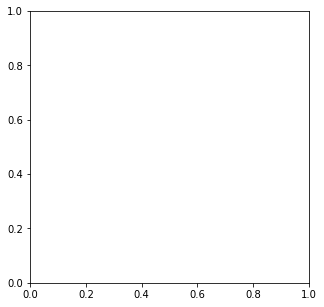

In [3]:
print(config)

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

device = "cuda" if torch.cuda.is_available() else "cpu"  # GPU 사용 가능 여부에 따라 device 정보 저장

sorted_df = setup_loader(config)

# train.json / validation.json / test.json 디렉토리 설정
train_path = config.dataset_path + '/train.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

In [4]:
augmentation_module = getattr(import_module("transforms.Augmentations"), config.augmentation)
train_transform = augmentation_module(mode='train')
train_dataset = CustomDataLoader2(data_dir=train_path, sorted_df=sorted_df, mode='train', transform=train_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=config.batch_size,
                                          num_workers=2,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=3.47s)
creating index...
index created!


Start extracting..
([{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0003.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 0}], [{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0005.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1}], [{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0006.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2}], [{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0007.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 3}], [{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0010.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 4}], [{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0011.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 5}], [{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0012.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 6}], [{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0013.jpg', 'height': 5

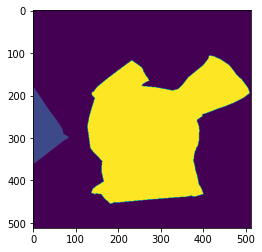

In [5]:
print('Start extracting..')
for images, masks, informs, cocoImgs in iter(train_loader):
    images = torch.stack(images)  # (batch, channel, height, width)
    masks = torch.stack(masks).long()  # (batch, channel, height, width)
    B = images.shape[0]
    print(cocoImgs)
    for i in range(B):
        image = images[i]
        mask = masks[i]
        inform = informs[i]
        cocoImg = cocoImgs[i]
        print(image.shape)
        print(mask.shape)
        print(inform)
        print(cocoImg)
        plt.imshow(mask)
        break
    break

In [7]:
def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id'] == classID:
            return cats[i]['name']
    return "None"


from torch.utils.data import Dataset, DataLoader
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from glob import glob

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO


coco = COCO('../input/data/train.json')
category_names = list(sorted_df.Categories)

loading annotations into memory...
Done (t=3.70s)
creating index...
index created!


In [19]:
image_id = coco.getImgIds(imgIds=0)
image_infos = coco.loadImgs(image_id)[0]
print(image_id)
print(coco.loadImgs(image_id))
print(image_infos)

[0]
[{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0003.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 0}]
{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0003.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 0}


In [20]:
# cv2 를 활용하여 image 불러오기
images = cv2.imread(os.path.join('../input/data', image_infos['file_name']))
images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
# images /= 255.0

ann_ids = coco.getAnnIds(imgIds=image_infos['id'])
anns = coco.loadAnns(ann_ids)
print(ann_ids)
print(anns)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[{'id': 0, 'image_id': 0, 'category_id': 8, 'segmentation': [[184, 455, 183, 455, 182, 455, 181, 455, 181, 454, 180, 454, 180, 453, 179, 453, 179, 452, 178, 452, 178, 451, 177, 451, 177, 450, 176, 450, 176, 449, 175, 449, 175, 448, 174, 448, 174, 447, 173, 447, 172, 447, 172, 446, 171, 446, 171, 445, 170, 445, 170, 444, 169, 444, 169, 443, 168, 443, 168, 442, 167, 442, 167, 441, 166, 441, 166, 440, 166, 439, 165, 439, 165, 438, 164, 438, 164, 437, 163, 437, 163, 436, 163, 435, 162, 435, 162, 434, 161, 434, 161, 433, 160, 433, 160, 432, 159, 432, 158, 432, 157, 432, 156, 432, 155, 432, 154, 432, 153, 432, 152, 432, 152, 431, 151, 431, 150, 431, 149, 431, 148, 431, 147, 432, 147, 432, 146, 433, 146, 433, 145, 433, 145, 432, 144, 432, 143, 432, 143, 431, 142, 431, 141, 431, 140, 431, 140, 430, 139, 430, 138, 430, 137, 430, 137, 429, 137, 428, 138, 427, 138, 427, 138, 426, 139, 425, 139, 425, 139, 424, 139, 423, 140, 422, 140, 422, 140, 421, 1

In [21]:
len(anns)

14

In [22]:
print(anns[0])
print(anns[1])

{'id': 0, 'image_id': 0, 'category_id': 8, 'segmentation': [[184, 455, 183, 455, 182, 455, 181, 455, 181, 454, 180, 454, 180, 453, 179, 453, 179, 452, 178, 452, 178, 451, 177, 451, 177, 450, 176, 450, 176, 449, 175, 449, 175, 448, 174, 448, 174, 447, 173, 447, 172, 447, 172, 446, 171, 446, 171, 445, 170, 445, 170, 444, 169, 444, 169, 443, 168, 443, 168, 442, 167, 442, 167, 441, 166, 441, 166, 440, 166, 439, 165, 439, 165, 438, 164, 438, 164, 437, 163, 437, 163, 436, 163, 435, 162, 435, 162, 434, 161, 434, 161, 433, 160, 433, 160, 432, 159, 432, 158, 432, 157, 432, 156, 432, 155, 432, 154, 432, 153, 432, 152, 432, 152, 431, 151, 431, 150, 431, 149, 431, 148, 431, 147, 432, 147, 432, 146, 433, 146, 433, 145, 433, 145, 432, 144, 432, 143, 432, 143, 431, 142, 431, 141, 431, 140, 431, 140, 430, 139, 430, 138, 430, 137, 430, 137, 429, 137, 428, 138, 427, 138, 427, 138, 426, 139, 425, 139, 425, 139, 424, 139, 423, 140, 422, 140, 422, 140, 421, 141, 420, 141, 420, 142, 419, 142, 419, 143, 418,

In [12]:
# Load the categories in a variable
cat_ids = coco.getCatIds()
cats = coco.loadCats(cat_ids)
print(cat_ids)
print(cats)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[{'id': 0, 'name': 'UNKNOWN', 'supercategory': 'UNKNOWN'}, {'id': 1, 'name': 'General trash', 'supercategory': 'General trash'}, {'id': 2, 'name': 'Paper', 'supercategory': 'Paper'}, {'id': 3, 'name': 'Paper pack', 'supercategory': 'Paper pack'}, {'id': 4, 'name': 'Metal', 'supercategory': 'Metal'}, {'id': 5, 'name': 'Glass', 'supercategory': 'Glass'}, {'id': 6, 'name': 'Plastic', 'supercategory': 'Plastic'}, {'id': 7, 'name': 'Styrofoam', 'supercategory': 'Styrofoam'}, {'id': 8, 'name': 'Plastic bag', 'supercategory': 'Plastic bag'}, {'id': 9, 'name': 'Battery', 'supercategory': 'Battery'}, {'id': 10, 'name': 'Clothing', 'supercategory': 'Clothing'}]


In [15]:
print(anns[0])

{'id': 15, 'image_id': 2, 'category_id': 6, 'segmentation': [[297, 417, 296, 417, 295, 417, 294, 417, 293, 417, 292, 417, 292, 416, 291, 416, 291, 415, 291, 414, 290, 414, 289, 414, 288, 414, 287, 414, 287, 413, 286, 413, 286, 412, 285, 412, 284, 412, 283, 412, 282, 412, 281, 413, 282, 413, 283, 413, 284, 413, 284, 414, 284, 414, 283, 415, 283, 416, 283, 416, 282, 416, 282, 415, 281, 415, 280, 415, 279, 415, 279, 414, 278, 414, 277, 414, 276, 414, 275, 414, 275, 413, 275, 412, 275, 411, 276, 410, 277, 410, 277, 410, 277, 409, 277, 408, 276, 408, 275, 408, 274, 408, 274, 407, 274, 406, 274, 405, 274, 404, 275, 403, 276, 403, 277, 403, 277, 403, 277, 402, 278, 401, 278, 401, 279, 400, 279, 400, 280, 399, 280, 399, 280, 398, 280, 397, 279, 397, 278, 398, 278, 398, 277, 398, 276, 398, 275, 398, 276, 397, 276, 397, 276, 396, 276, 395, 276, 394, 277, 393, 278, 393, 279, 393, 279, 393, 279, 392, 278, 392, 277, 392, 276, 392, 275, 392, 275, 391, 274, 391, 273, 392, 274, 392, 274, 393, 274, 393

In [16]:
# masks : size가 (height x width)인 2D
# 각각의 pixel 값에는 "category id + 1" 할당
# Background = 0

masks_list = []
for e in anns:
    masks_list.append(np.zeros((image_infos["height"], image_infos["width"])))
masks = np.zeros((image_infos["height"], image_infos["width"]))

In [17]:
# Unknown = 1, General trash = 2, ... , Cigarette = 11
for i in range(len(anns)):
    className = get_classname(anns[i]['category_id'], cats)
    pixel_value = category_names.index(className)
    mask = coco.annToMask(anns[i])
    # mask = self.transform(image=masks, mask=mask)['mask'].numpy()
    masks_list[i] = np.maximum(mask * pixel_value, masks)
# masks = masks.astype(np.float32)
print(masks_list)

[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])]


In [ ]:
# transform -> albumentations 라이브러리 활용
if self.transform is not None:
    transformed = self.transform(image=images, mask=masks)
    images = transformed["image"]
    masks = transformed["mask"]

# return images, masks, image_infos, self.coco.loadImgs(image_id)